In [8]:
# Imports
import numpy as np
import pandas as pd
import pickle

import os

import scipy.io.wavfile as wav

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.animation as animation

from obspy import read
from obspy import UTCDateTime

In [9]:
# Constants
victoria_lat = 48.4284  # coordinates of Victoria, BC, general center location where we will look
victoria_lon = -123.3656
day0 = np.datetime64('2009-08-01 00:00:00')

In [10]:
# Load seismic data
st = read("data/CN.CLRS.HHN_010824_120924.sac", format="SAC")
station = pickle.load(open("data/CN.CLRS.HHN_010824_120924.pkl", "rb"))

print(station)
print(st)

# Quick processing
st.taper(type="cosine", max_percentage=0.05)
st_filt = st.copy()

st_filt.filter("bandpass", freqmin=1, freqmax=10)  # in tremor frequency band
st.filter("bandpass", freqmin=.001, freqmax=50)  # remove noise

Station CLRS (Cowichan Lake Research St, BC, CA)
	Station Code: CLRS
	Channel Count: 3/15 (Selected/Total)
	2014-09-11T00:00:00.000000Z - 
	Access: open 
	Latitude: 48.8203, Longitude: -124.1309, Elevation: 174.0 m
	Available Channels:
	    ..HH[ZNE]   100.0 Hz  2016-09-07 to None

1 Trace(s) in Stream:
CN.CLRS..HHN | 2024-08-01T00:00:00.000000Z - 2024-09-12T14:43:29.750000Z | 100.0 Hz, 368180976 samples


/Users/gaspard/mambaforge/envs/sono/lib/python3.11/site-packages/obspy/signal/filter.py:62: UserWarning:

Selected high corner frequency (50) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.



1 Trace(s) in Stream:
CN.CLRS..HHN | 2024-08-01T00:00:00.000000Z - 2024-09-12T14:43:29.750000Z | 100.0 Hz, 368180976 samples

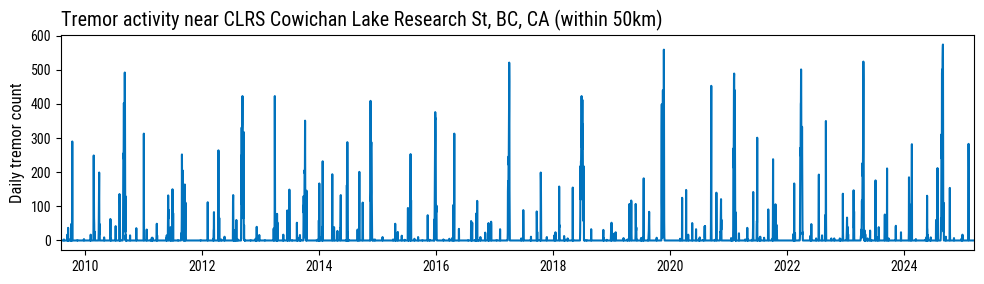

In [11]:
# Load tremor
trm = pd.read_csv("data/tremor_events-2009-08-06T00_00_00-2025-03-19T23_59_59.csv", low_memory=False)

trm["date"] = pd.to_datetime(trm["starttime"])
trm["day"] = (trm["date"] - day0) / np.timedelta64(1, 'D')

# Select tremor events a certain radius below the station
radius = 50  # in km
dx = (trm.lon - station.longitude) * 111.32 * np.cos(np.radians(trm.lat.mean()))
dy = (trm.lat - station.latitude) * 111.32

dist = np.sqrt(dx**2 + dy**2)
trm["dist2sta"] = dist

trm_sta = trm.copy()
trm_sta = trm_sta[dist < radius]

# Show activity
trm_count, count_time = np.histogram(trm_sta.day, bins=np.arange(0, trm.day.max(), 1))  # count of daily tremor
count_time = count_time[:-1] + 0.5
count_date = day0 + count_time * np.timedelta64(1, "D")

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_ylabel("Daily tremor count")
ax.set_title(f"Tremor activity near {station.code} {station.site.name} (within {radius:.0f}km)", loc='left')

ax.plot(count_date, trm_count, label="Tremor count")

ax.set_xlim(count_date[0], count_date[-1])

plt.tight_layout()
plt.show()

In [12]:
# Select a time window to sonify
track_start_time = UTCDateTime("2024-08-24T00:00:00")
track_end_time = UTCDateTime("2024-08-29T00:00:00")

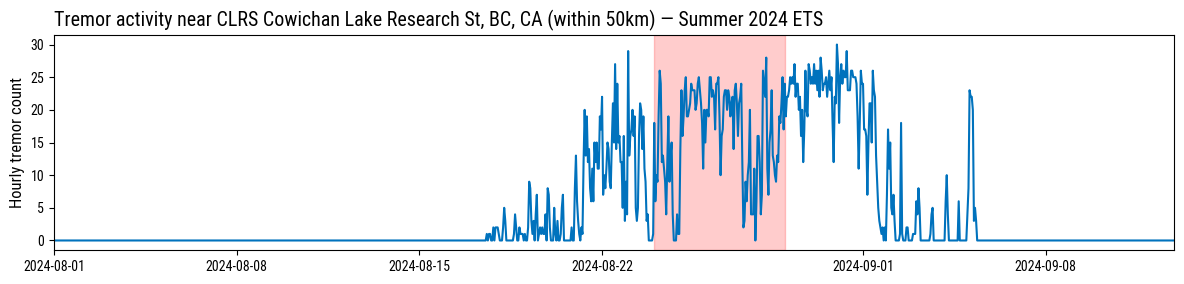

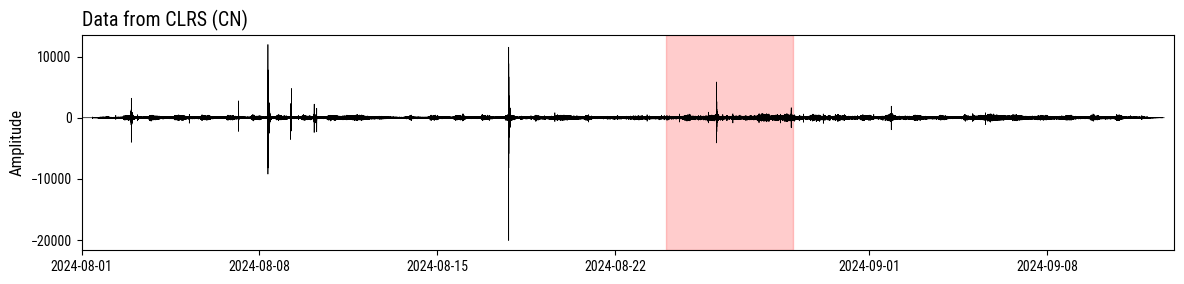

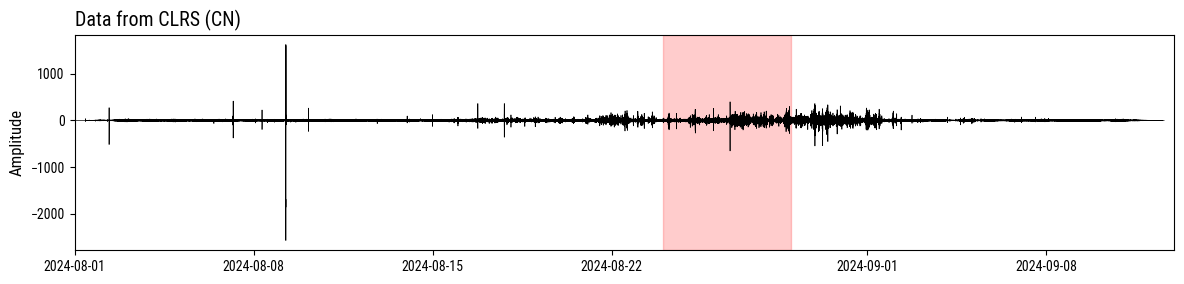

In [13]:
# Show episode of interest episode

# --> Tremor count
interval = (np.datetime64('2024-08-01'), np.datetime64('2024-09-13'))
in_interval = (trm_sta.date > interval[0]) & (trm_sta.date < interval[1])
trm_count_hf, count_time_hf = np.histogram(trm_sta[in_interval].day, bins=np.arange((interval[0] - day0)/np.timedelta64(1, "D"), (interval[1] - day0)/np.timedelta64(1, "D"), 1/24))  # count of hourly tremor
count_time_hf = count_time_hf[:-1] + 0.5/24
count_date_hf = day0 + count_time_hf*24*np.timedelta64(1, "h")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_ylabel("Hourly tremor count")
ax.set_title(f"Tremor activity near {station.code} {station.site.name} (within {radius:.0f}km) — Summer 2024 ETS", loc='left')

ax.plot(count_date_hf, trm_count_hf, label="Tremor count")

ax.axvspan(track_start_time, track_end_time, color=to_rgba("r", 0.2), label="Sonification time window", zorder=0)

ax.set_xlim(count_date_hf[0], count_date_hf[-1])

plt.tight_layout()
plt.show()

# --> Seismic data
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(np.datetime64(st[0].stats.starttime.datetime) + st[0].times()[::100] * np.timedelta64(1, "s"), st[0].data[::100], color="k", lw=0.5)  # subsampled for speed
ax.set_ylabel("Amplitude")
plt.title(f"Data from {station.code} ({st[0].stats.network})", loc='left')
ax.set_xlim(interval[0], interval[1])
ax.axvspan(track_start_time, track_end_time, color=to_rgba("r", 0.2), label="Sonification time window", zorder=0)
plt.tight_layout()
plt.show()

# Filter in the tremor band
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(np.datetime64(st_filt[0].stats.starttime.datetime) + st_filt[0].times()[::100] * np.timedelta64(1, "s"), st_filt[0].data[::100], color="k", lw=0.5)  # subsampled for speed
ax.set_ylabel("Amplitude")
plt.title(f"Data from {station.code} ({st_filt[0].stats.network})", loc='left')
ax.set_xlim(interval[0], interval[1])
ax.axvspan(track_start_time, track_end_time, color=to_rgba("r", 0.2), label="Sonification time window", zorder=0)
plt.tight_layout()
plt.show()

In [14]:
# Waveform to soundtrack parameters
speed_up = 500

print(f"Speed up: {speed_up}x")

print(f"\nOne day of data lasts {24 * 3600 / speed_up / 60:.0f} minutes")
print(f"One month of data lasts {30 * 24 * 3600 / speed_up / 60:.0f} minutes")
print(f"The chosen segment will last {((track_end_time - track_start_time) / speed_up) // 60 :.0f} min {((track_end_time - track_start_time) / speed_up) % 60:.0f} sec")

print(f"\nTremor frequency band: 1-10 Hz --> {speed_up * 1:.0f}-{speed_up * 10:.0f} Hz")
print(f"Seismic data sampling rate: {st[0].stats.sampling_rate:.0f} Hz --> {speed_up * st[0].stats.sampling_rate:.0f} Hz")

# Convert data time to track time
track_time = st[0].times() / speed_up  # in seconds
track_time = track_time - track_time[0]  # start at 0
print(track_time[0], track_time[-1] / 60)  # in minutes

Speed up: 500x

One day of data lasts 3 minutes
One month of data lasts 86 minutes
The chosen segment will last 14 min 24 sec

Tremor frequency band: 1-10 Hz --> 500-5000 Hz
Seismic data sampling rate: 100 Hz --> 50000 Hz
0.0 122.72699166666666


In [15]:
# Actually cut the data to the correct time window
st_filt_2sound = st_filt.copy()
st_2sound = st.copy()

st_filt_2sound.trim(track_start_time, track_end_time)
st_2sound.trim(track_start_time, track_end_time)

1 Trace(s) in Stream:
CN.CLRS..HHN | 2024-08-24T00:00:00.000000Z - 2024-08-29T00:00:00.000000Z | 100.0 Hz, 43200001 samples

In [16]:
# Resample data to 44100 Hz
# --> Track time
track_time = st_filt_2sound[0].times() / speed_up  # in seconds
track_time = track_time - track_time[0]  # start at 0

# --> Resample the track to 44100 Hz / speed_up: when sped up with the speed up factor, the track will be at 44100 Hz and last the predicted duration
audio_sampling_rate = 44100  # Hz
st_filt_2sound.resample(audio_sampling_rate / speed_up)
st_2sound.resample(audio_sampling_rate / speed_up)

1 Trace(s) in Stream:
CN.CLRS..HHN | 2024-08-24T00:00:00.000000Z - 2024-08-28T23:59:59.988662Z | 88.2 Hz, 38102400 samples

In [19]:
# Output raw waveforms
# --> A tiny taper to avoid clicks
st_filt_2sound.taper(max_percentage=0.01, type="cosine")
st_2sound.taper(max_percentage=0.01, type="cosine")

# --> Rescale the data to 16 bits
wvf_filt_16bit = st_filt_2sound[0].data / np.max(np.abs(st_filt_2sound[0].data)) * 32767
wvf_16bit = st_2sound[0].data / np.max(np.abs(st_2sound[0].data)) * 32767

# --> Save the data
basename = f"{st_2sound[0].stats.network}.{st_2sound[0].stats.station}.{st_2sound[0].stats.channel}_{st_2sound[0].stats.starttime.strftime('%d%m%y')}_{st_2sound[0].stats.endtime.strftime('%d%m%y')}"
wav.write(f"output/{basename}.wav", int(audio_sampling_rate), wvf_16bit.astype(np.int16))
wav.write(f"output/{basename}_trm.wav", int(audio_sampling_rate), wvf_filt_16bit.astype(np.int16))

print(f"Saving to sounds to {basename}...")

Saving to sounds to CN.CLRS.HHN_240824_280824...


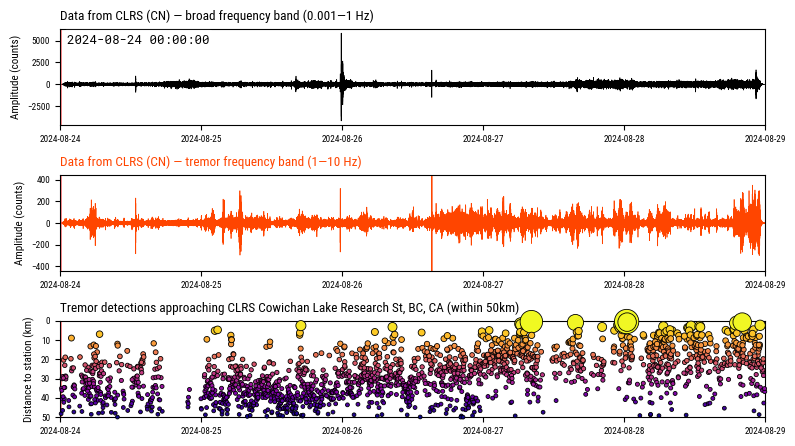

In [20]:
# A quick video of the data: seismic data and tremor detections with cursor -- Define background
# --> Function defining background
def background():
    # Set up the figure
    fig, axes = plt.subplots(3, 1, figsize=(8, 4.5))
    plt.rcParams.update({'font.size': 8})

    # For all axes
    for ax in axes:
        ax.set_xlim(track_start_time.datetime, track_end_time.datetime)
        minor_time_ticks = np.arange(track_start_time.datetime, track_end_time.datetime, np.timedelta64(1, "D"))
        ax.set_xticks(minor_time_ticks, minor=True)

    # Seismic data (all frequencies)
    ax = axes[0]
    ax.plot((np.datetime64(st_2sound[0].stats.starttime.datetime) + st_2sound[0].times() * np.timedelta64(1, "s"))[::10], st_2sound[0].data[::10], color="k", lw=0.5, rasterized=True)
    ax.set_ylabel("Amplitude (counts)")
    ax.set_title(f"Data from {station.code} ({st_2sound[0].stats.network}) — broad frequency band (0.001—1 Hz)", loc='left')

    # Tremor data (tremor band)
    ax = axes[1]
    ax.plot((np.datetime64(st_filt_2sound[0].stats.starttime.datetime) + st_filt_2sound[0].times() * np.timedelta64(1, "s"))[::10], st_filt_2sound[0].data[::10], color="orangered", lw=0.5, rasterized=True)
    ax.set_ylabel("Amplitude (counts)")
    ax.set_title(f"Data from {station.code} ({st_filt_2sound[0].stats.network}) — tremor frequency band (1—10 Hz)", loc='left', c="orangered")

    ax.set_ylim(-10*np.percentile(st_filt_2sound[0].data, 99), 10*np.percentile(st_filt_2sound[0].data, 99))

    # Tremor detections
    ax = axes[2]
    ax.set_title(f"Tremor detections approaching {station.code} {station.site.name} (within {radius:.0f}km)", loc='left')
    ax.set_ylabel("Distance to station (km)")

    in_track = (trm_sta.date > track_start_time.datetime) & (trm_sta.date < track_end_time.datetime)
    trm_track = trm_sta[in_track]
    
    ax.scatter(trm_track.date, trm_track["dist2sta"], s=(1/trm_track["dist2sta"]) * 120 + 5, c=trm_track["dist2sta"], cmap="plasma_r", edgecolor="k", lw=.6, clip_on=False, zorder=10)
    ax.set_ylim(50, 0)

    cursors = []
    for ax in axes:
        l = ax.axvline(track_start_time, color="r", lw=2, alpha=0.5)
        cursors.append(l)

    txt_time =  axes[0].text(0.01, 0.95, track_start_time.strftime("%Y-%m-%d %H:%M:%S"), fontsize=9, transform=axes[0].transAxes, 
                    ha='left', va='top', bbox={'boxstyle':'round', 'facecolor':to_rgba('w', .5), 'edgecolor':'none'},
            fontname='Roboto Mono')

    plt.tight_layout()
    return fig, axes, cursors, txt_time

fig, axes, cursors, txt_time = background()
plt.show()

In [21]:
# Animation parameters
short_title = basename
print(short_title)
outdir = './output/'
filename = '{:}.mp4'.format(short_title)
out_path = outdir + filename

dpi = 200  # resolution
fps = 1  # frames per second, it’s not high resolution, the cursor moves SLOWLY
duration = track_time[-1]  # seconds, duration of the animation, same as the audio track
N_frames = int(fps * duration)  # number of frames in the animation
dt_frame = (track_end_time - track_start_time) / N_frames  # time step between frames, in data time

metadata = dict(title='Waveform visualization', artist='Matplotlib', comment='...')                                                                                   
writer = animation.FFMpegWriter(fps=fps, bitrate=-1)

CN.CLRS.HHN_240824_280824


Writing frames...


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_77664/3153272931.py:15: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later



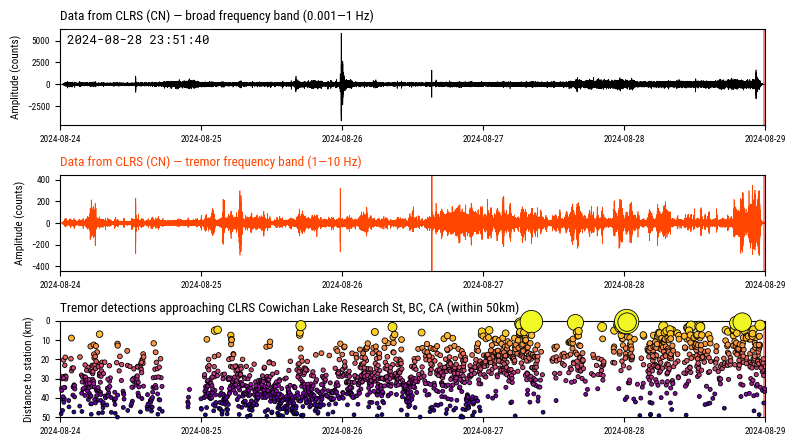

In [22]:
# Animate (far too long... but that’s the only way I know)
# --> Initialize background
fig, axes, cursors, txt_time = background()

# --> Animate
with writer.saving(fig, out_path, dpi):
    print('Writing frames...')
    for iframe in range(N_frames):
        print('Frame {:}/{:}'.format(iframe, N_frames), end='\r')
        # Update time
        time = track_start_time + iframe * dt_frame

        # Update cursor
        for cursor in cursors:
            cursor.set_xdata(time.datetime)
        
        # Update text
        txt_time.set_text(time.strftime("%Y-%m-%d %H:%M:%S"))

        # Update figure
        fig.canvas.draw()

        # Grab frame
        writer.grab_frame()

In [ ]:
# Stitch together using ffmpeg
# To stitch mp4 and mp3 files, using ffmpeg command, use:
# `ffmpeg -i video.mp4 -i audio.wav -c:v copy -c:a aac output.mp4`    
os.system(f"ffmpeg -i {out_path} -i {out_path[:-4]}_trm.wav -c:v copy -c:a aac {out_path[:-4]}_wsound.mp4")
print(f"Saving video to {out_path[:-4]}_wsound.mp4...")
print("Done!")

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 16.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1706918698529/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1706918698529/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass -

Saving video to ./output/CN.CLRS.HHN_240824_280824_wsound.mp4...
Done!


[out#0/mp4 @ 0x151e16c50] video:2233kB audio:7362kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.708965%
size=    9759kB time=00:14:23.99 bitrate=  92.5kbits/s speed= 195x    
[aac @ 0x152813590] Qavg: 262.527


In [ ]:
# import numpy as np
# import matplotlib.pylab as plt
# import matplotlib.animation as animation
# import subprocess

# def testSubprocess(x, y):

#     #set up the figure
#     fig = plt.figure(figsize=(15, 9))
#     canvas_width, canvas_height = fig.canvas.get_width_height()

#     # First frame
#     ax0 = plt.plot(x,y)
#     pointplot, = plt.plot(x[0], y[0], 'or')

#     def update(frame):
#         # your matplotlib code goes here
#         pointplot.set_data(x[frame],y[frame])

#     # Open an ffmpeg process
#     outf = 'testSubprocess.mp4'
#     cmdstring = ('ffmpeg', 
#                  '-y', '-r', '1', # overwrite, 1fps
#                  '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
#                  '-pix_fmt', 'argb', # format
#                  '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
#                  '-vcodec', 'mpeg4', outf) # output encoding
#     p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

#     # Draw frames and write to the pipe
#     for frame in range(nframes):
#         # draw the frame
#         update(frame)
#         fig.canvas.draw()

In [ ]:
# import multiprocessing
# import math
# import os

# # divide into chunks (https://stackoverflow.com/a/312464/3253411)
# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in xrange(0, len(lst), n):
#         yield lst[i:i + n]

# # number of total frames
# frames=1000
# frame_iter=[i for i in range(frames)]

# # distribute the frames over a set of equally sized chunks
# chunk_size=math.ceil(number/multiprocessing.cpu_count())
# frame_chunks=list(chunks(frames,chunk_size))

# # get temporary video files to write to
# filenames=["_temp_video_chunk_" + str(i) + ".mp4") for i in range(len(frame_chunks))]

# def ani_to_mp4(frame_set, filename):
#     """Animate figure fig for a defined frame set and save in filename (based n (https://stackoverflow.com/a/31315362/3253411)"""
#     canvas_width, canvas_height = fig.canvas.get_width_height()

#     # Open an ffmpeg process
#     outf = os.path.join("results", filename)
#     cmdstring = ('ffmpeg', 
#                     '-y', '-r', '100', # fps
#                     '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
#                     '-pix_fmt', 'argb', # formats
#                     '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
#                     '-vcodec', 'mpeg4', outf) # output encoding
#     p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

#     # Draw frames and write to the pipe
#     for frame in frame_range:
#         # draw the frame
#         animate(frame)
#         fig.canvas.draw()

#         # extract the image as an ARGB string
#         string = fig.canvas.tostring_argb()

#         # write to pipe
#         p.stdin.write(string)

#     # Finish up
#     p.communicate()

# # take the function to write parallelized the animation chunks to the filenames
# with multiprocessing.Pool() as pool:
#     pool.starmap(ani_to_mp4, zip(frame_sets, filenames))

# # write the filename list to a file
# with open("filenames.txt", "w") as textfile:
#     for filename in filenames:
#         textfile.write("file '" + filename + "'\n")

# # and use ffmpeg to concat the resulting mp4 files
# cmdstring = ('ffmpeg', '-y',
#                 '-f', 'concat', 
#                 '-safe', '0', 
#                 '-i', "filenames.txt",
#                 '-c', 'copy', 
#                 'output.mp4') # output encoding
# p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)